### Import

In [1205]:
import numpy as np
import sympy as sp

import matplotlib
import matplotlib.pyplot as plt

from sympy import Matrix, init_printing

import qiskit
from qiskit import *

# Representing Data
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

# Monitor Job on Real Machine
from qiskit.tools.monitor import job_monitor

from functools import reduce # perform sucessive tensor product

# Calculating cost
from sklearn.metrics import mean_squared_error

# Generating random unitary matrix
from scipy.stats import unitary_group

### Problem

Implement a circuit which returns |00> and |11> with equal probability.

Requirements :

- Circuit should consist only of CNOTs, RXs and RYs. 

- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 

- You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 

- Simulations must be done with sampling - i.e. limited number of measurements per iteration and noise. 

- Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:

- How to make sure you produce state $|00\rangle +|11 \rangle$ and not $|00\rangle - |11\rangle$ ?


### Helpful Resources

In [537]:
# Matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
H = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])

# Eigenvectors of Pauli Matrices
zero = np.array([[1], [0]]) # Z plus basis state
one = np.array([[0], [1]]) # Z plus basis state

plus = np.array([[1], [1]])/np.sqrt(2) # X plus basis state
minus = np.array([[1], [-1]])/np.sqrt(2) # X minus basis state

up = np.array([[1], [1j]])/np.sqrt(2) # Y plus basis state
down = np.array([[1], [-1j]])/np.sqrt(2) # Y plus basis state

# Bell States
B00 = np.array([[1], [0], [0], [1]])/np.sqrt(2) # Bell of 00
B01 = np.array([[1], [0], [0], [-1]])/np.sqrt(2) # Bell of 01
B10 = np.array([[0], [1], [1], [0]])/np.sqrt(2) # Bell of 10
B11 = np.array([[0], [-1], [1], [0]])/np.sqrt(2) # Bell of 11

# Rn Matrix Function
Rx = lambda theta: np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]])
Ry = lambda theta: np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
Rz = lambda theta: np.array([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]])

### View Matrix

In [15]:
def view(mat):
    display(Matrix(mat))

### Get Unitary/StateVector Function

In [16]:
# This function return the statevector or the unitary of an inputted circuit

def get(circ, types = 'unitary'):
    if types == 'statevector':
        backend = BasicAer.get_backend('statevector_simulator')
        out = execute(circ, backend).result().get_statevector()
    else: 
        backend = BasicAer.get_backend('unitary_simulator')
        out = execute(circ, backend).result().get_unitary()
        
    return display(Matrix(np.round(out, 10)))

### Draw Neural Networks

In [17]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
                
                
# Draw neural network for this problem
def draw_nn():
    fig = plt.figure(figsize=(8, 8))

    fig.text(0.15, 0.76, 'Input Layer', fontsize = 12)
    fig.text(0.75, 0.76, 'Output Layer', fontsize = 12)

    # Input Layer
    fig.text(0.177, 0.65, 'x_0', fontsize = 16)
    fig.text(0.177, 0.35, 'x_1', fontsize = 16)
    
    # Output Layer
    fig.text(0.795, 0.65, 'y_0', fontsize = 16)
    fig.text(0.795, 0.35, 'y_1', fontsize = 16)

    ax = fig.gca()
    ax.axis('off')
    draw_neural_net(ax, .1, .9, .1, .9, [2, 2])


### Gram-Schmidt Process

In [1117]:
def gs_cofficient(v1, v2):
    return numpy.dot(v2, v1) / numpy.dot(v1, v1)

def multiply(cofficient, v):
    return map((lambda x : x * cofficient), v)

def proj(v1, v2):
    return multiply(gs_cofficient(v1, v2) , v1)

def gs(X):
    Y = []
    for i in range(len(X)):
        temp_vec = X[i]
        for inY in Y :
            proj_vec = proj(inY, X[i])
            #print "i =", i, ", projection vector =", proj_vec
            temp_vec = map(lambda x, y : x - y, temp_vec, proj_vec)
            #print "i =", i, ", temporary vector =", temp_vec
        Y.append(temp_vec)
    return Y

### Plan

    1. Create a quantum circuit with Hamadamard and CX

    2. Decompose Hadamard into R_X and R_Y using gate decomposition

    3. Draw Neural Network graph

    4. Create data to train/test

    5. Initialized weights

    6. Implement Forward Propagation

    7. Define Cost function

    8. Implement Backpropagation

    9. Implement Gradient Descent to updates the weights in each layers
    
    10. Check that each layer is implemented correctly
    
    11. Train Model
    
    12. Evaluate Model
    
    13. Full Optimization Implementation
    
    14. Sampling on Quantum Circuit
    

Optional:

    - Implement Adam Optimization
    - Implement General Neural Network
    - Implement Forward Prop with simulation
    - Bonus question

### Step 1: Build Bell Circuit

Create a quantum circuit with Hadamard and CX

Typically, a circuit to create the $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ looks like this

```python
# Quantum Circuit with Hadamard and CX
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)

circ.draw('mpl')
```

The outputs of the four CBS for this circuit are the following

Let matrix B represents the unitary of the circuit

$$B |00\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$$

$$B |01\rangle = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle)$$

$$B |10\rangle = \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle)$$

$$B |11\rangle = \frac{1}{\sqrt{2}} (-|01\rangle + |10\rangle)$$

### Step 2: Hadamard Decomposition

Decompose Hadamard into $R_X(\phi)$ and $R_Y(\theta)$ using gate decomposition

#### Hadamard

$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1\\ 1 & -1  \end{bmatrix}$$

#### X-axis Rotation

$$R_X( \theta ) = \begin{bmatrix} cos \frac{\theta}{2} & -i sin \frac{\theta}{2} \\ -i sin \frac{\theta}{2} & cos \frac{\theta}{2}  \end{bmatrix}$$

#### Y-axis Rotation

$$R_Y( \theta ) = \begin{bmatrix} cos \frac{\theta}{2} & -sin \frac{\theta}{2} \\ sin \frac{\theta}{2} & cos \frac{\theta}{2}  \end{bmatrix}$$

The Hadamard decomposition is as followed:

$$H = R_y(-\frac{\pi}{2})R_x(\pi)$$

Subsequently, the new circuit will looks like this

```python

# Implement a R_y, R_x circuit. Notice that the order is flipped
circ = QuantumCircuit(2)
circ.rx(np.pi, 0)
circ.ry(-np.pi/2, 0)
circ.cx(0, 1)

circ.draw('mpl')

```

The outputs of the four CBS for this circuit are the following

Let matrix M represents the unitary of the circuit

$$M |00\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$$

$$M |01\rangle = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle)$$

$$M |10\rangle = \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle)$$

$$M |11\rangle = \frac{1}{\sqrt{2}} (-|01\rangle + |10\rangle)$$

This is the same as the normal Bell states circuit

### Step 3: Draw Neural Network

The neural network for this aims to mimic the $R_y(-\frac{\pi}{2})R_x(\pi)$ matrix complex

When plugging in the correct value, the $-i$ factors on the $R_x(\phi)$ eventually dissapear as a global phase. 

Because of this, we can frame the $R_x(\phi)$ in a simpler form

$$R_y(\theta)R_x(\phi)(X) = \begin{bmatrix} cos \frac{\theta}{2} & -sin \frac{\theta}{2} \\ sin \frac{\theta}{2} & cos \frac{\theta}{2}  \end{bmatrix} \begin{bmatrix} cos \frac{\phi}{2} & sin \frac{\phi}{2} \\ sin \frac{\phi}{2} & cos \frac{\phi}{2}  \end{bmatrix} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix}$$

The middle two matrices can be reduced into sum and difference formula

$$R_y(\theta)R_x(\phi)(X) = \begin{bmatrix} cos\frac{\phi + \theta}{2} & sin\frac{\phi - \theta}{2} \\ sin\frac{\phi + \theta}{2} & cos\frac{\phi - \theta}{2}\end{bmatrix} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix}$$

This neural network has one layers, each layers with two nodes, and each nodes with two weights. We can set the weight matrix $W$ as follow:

$$W = \begin{bmatrix} cos\frac{\phi + \theta}{2} & sin\frac{\phi - \theta}{2} \\ sin\frac{\phi + \theta}{2} & cos\frac{\phi - \theta}{2}\end{bmatrix} = \begin{bmatrix} \alpha & \beta \\ \gamma & \delta \end{bmatrix}$$

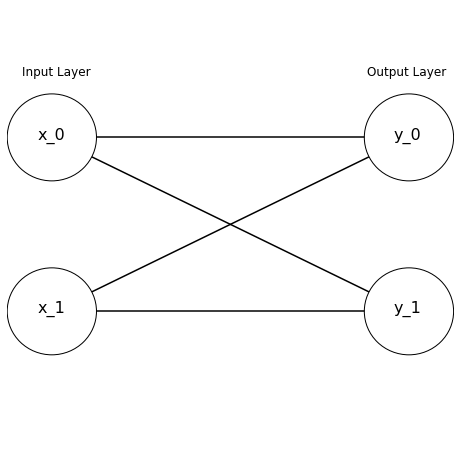

In [21]:
draw_nn()

###### Each nodes in the hidden layer and the output layer contains two weights

The square bracket index represents the layer the node is in.

The curly bracket index represents the position of the node in its respective layer.

###### Output Layer

$$y_0 = W^{[1]\{0\}} \cdot X$$

Where $W^{[1]\{0\}} = \begin{pmatrix} \alpha \\ \beta \end{pmatrix}$, $\alpha$ and $\beta$ are parameters

From this, we can see that the output equals

$$ y_0 = \alpha x_0 + \beta x_1 $$

Also,

$$y_1 = \gamma x_0 + \delta x_1$$

### Step 4: Create data

There are two approachs to doing this: 

1. Create a small number of training examples so the algorithm intentionally overfits the data ( < 10 $(X, y)$ pairs)
2. Create a large number of training examples so the algorithm can be more robust ( > 1000 $(X, y)$ pairs)

Both approachs will be attempted and the better of the two will be chosen

Steps to creating data:

1. Randomize a 2-d real unit vectors, this is $X$ (for this purpose, ignore complex number)
2. Using the known matrix, take the product of the two, this is $y$
3. Repeat the process $n$ times as deemed necessary

#### Single Vector Implementation

```python
M_correct = H

### X-values

# Create a random 2-d real vector
x = np.random.rand(2, 1)

# Normalize v
x /= np.linalg.norm(x)

### Y-values

# Matrix Multiplication
y = np.dot(M_correct, x)
```

#### Multiple Vectors Implementation

In [418]:
def create_data(M_correct, size = 500, train_split = 0.7, seed = 0):
    
    """
    
    Create two matrices of specified length consisting of 2-d vectors representing
    a train and a test examples
    
    Parameters
    ----------
    M_correct: ndarray
        Matrix that transform the input to the correct output
    size: int
        Number of examples (train & test) in the dataset
    train_split: float
        Proportion of the train data to the total dataset
        
    
    Returns
    -------
    X_train: ndarray
        Matrix containing the x-values of all the training examples
    y_train: ndarray
        Matrix containing the y-values of all the training examples
    X_test: ndarray
        Matrix containing the x-values of all the testing examples
    y_test: ndarray
        Matrix containing the y-values of all the testing examples

    """
    
    np.random.seed(seed)
    
    # Manage defaults for 'size'
    if size == 'small':
        size = 10
    elif size == 'large':
        size = 1000
    
    ### X-values
    
    # Create a random matrix of 2-d real vectors as columns
    X = np.random.rand (2, size)
    
    # Normalize v by column axix
    X /= np.linalg.norm(X, axis = 0)
    
    # Check for normalization
    assert np.round(np.sum(np.power(X, 2)), 10) == size, 'X is not normalized'
    
    # Check for correct shape
    assert X.shape == (2, size), 'the shape of X is not correct'
    
    ### Y-values
    
    # Matrix Multiplication
    y = np.dot(M_correct, X)
    
    # Check for unitary
    assert np.round(np.sum(np.dot(M_correct, M_correct.conj().T)), 10) == 2, 'M_correct is not unitary'
    
    # Check for correct shape
    assert y.shape == (2, size), 'the shape of y is not correct'
    
    # Splitting the matrix into its corresponding groups
    
    X_train = X[:, :int(size*train_split)]
    y_train = y[:, :int(size*train_split)]
    
    X_test = X[:, int(size*train_split):]
    y_test = y[:, int(size*train_split):]
    
    return X_train, y_train, X_test, y_test

### Step 5: Initialization
The $W$ matrix will be initialized to all zeros or randomly

In [1038]:
def initialize(init_type = 'random', dim = (2, 2), seed = 0):
    
    """
    
    Initialize the W matrix of a specified size to all zeros or randomly
    
    Parameters
    ----------
    init_type: str
        Specify whether W will be initialized to all zeros or randomly
    shape: tuple
        Specify shape of W
    seed: int
        Used for pseudo-randomly generate matrix
    
    Returns
    -------
    W: ndarray
        Initialized W matrix (all zeros or pseudo-random)
        
    """
      
    # Zero Initialization
    if init_type == 'zeros':
        
        W = np.zeros(dim)  
        
    # Random Initialization
    else:
        # Keep the values consistent
        np.random.seed(seed)

        W = np.random.rand(*dim)

    # Check for W shape
    assert W.shape == dim, 'shape of W is not correct'
        
    return W

### Step 6: Forward Propagation

Forward propagation passes the input into the neural network to predict an output value

$$\hat{y} = \underbrace{\begin{bmatrix} \alpha & \beta \\ \gamma & \delta \end{bmatrix}}_{W} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix}$$

To run multiple training examples at the same time (stochastic), put the training examples into a matrix a multiply it with the weight matrix. The index of training examples will be represented by the superscript inside the parentheses.

$$W(X) \ = \ W \begin{pmatrix} x_0^{(0)} & x_0^{(1)} ... & \ x_0^{(n)} \\ x_1^{(0)} & x_1^{(1)} ... & \ x_1^{(n)} \end{pmatrix} \ = \ \begin{pmatrix} \hat{y}^{(0)} & \hat{y}^{(1)} & ... & \hat{y}^{(n)}\end{pmatrix}$$

There are two ways of running forward propagation:

1. Simulate the circuit using 'qasm_simulator' 

    - This is less practical because it requires taking the square root of the count probability to get back to the weights.
    
    
2. Calculate the output value using directly using linear algebra

    - Forward prop will be calculated using this method at the moment

In [25]:
def forward_prop(W, X, path = None):
    
    """
    
    Perform the forward propagation step
    
    Parameters
    ----------
    W: ndarray
        Matrix of the weights in used
    X: ndarray 
        Matrix of x-values
    path: str
        Specify whether the forward prop is done classically or using a quantum simulator
    
    Returns
    -------
    y_hat: ndarray
        Predicted value to be used for back-prop
        
    """
    
    # Simulate using 'qasm simulator'
    if path == 'sim':
        pass
    
    # Calculate using linear algebra
    else:
        y_hat = np.dot(W, X)
        
    # Make sure the shape is consistent
    assert X.shape == y_hat.shape, 'Shape is not consistent'
    
    return y_hat

### Step 7: Define Cost Function

Because this is a regression problem, we will calculate the cost using Half Mean Squared Error (MSE), which we will define as

$$J(W) = \frac{1}{2N} \sum^{N}_{i=1} \underbrace{||y_i - \hat{y}_i||^2}_{L(W)}$$

where $N$ is the number of training examples

In [26]:
def cost(y, y_hat):
    
    """
    
    Compute half mean-squared error cost
    
    Parameters
    ----------
    y: ndarray
        The true y value generated from a preset matrix (see step 4: Create Data)
    y_hat: ndarray
        The predicted y value from a learned set of weights (see step 6: Forward Propagation)
    
    Returns
    -------
    J: float
        Scalar matrix to indicate the overall performance of the current set of weights
    
    """
    
    # N is number of training examples
    N = y.shape[1]
    
    # Compute cost function
    J = 1/(2*N) * np.sum(np.linalg.norm(y - y_hat)**2)
    
    return J

### Step 8: Backpropagation

Expanding the matrices from above (only caring about the subscript, we have)

$$\hat{y} = \begin{bmatrix} cos\frac{\phi + \theta}{2} & sin\frac{\phi - \theta}{2} \\ sin\frac{\phi + \theta}{2} & cos\frac{\phi - \theta}{2}\end{bmatrix} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix} = \underbrace{\begin{bmatrix} \alpha & \beta \\ \gamma & \delta \end{bmatrix}}_{W} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix} = \begin{pmatrix} \alpha x_0 + \beta x_1 \\ \gamma x_0 + \delta x_1 \end{pmatrix}$$

To find the local minimum, update the parameters opposite of the direction of steepest descent. Backpropagation calculates derivative of the cost function with respect to each of the weights.

From above

$$J(W) = \frac{1}{2N} \sum^{N}_{i=1} \underbrace{||y_i - \hat{y}_i||^2}_{L(W)}$$

The cost function can be written as 

$$J(W) = \frac{1}{2N} \sum^{N}_{i=1} \begin{Vmatrix} y_0 - (\alpha x_0 + \beta x_1) \\ y_1 - (\gamma x_0 + \delta x_1) \end{Vmatrix}^2 = \frac{1}{2N} \sum^{N}_{i=1} \overbrace{{\underbrace{[(\alpha x_0 + \beta x_1 - y_0]}_{L_0}}^2 + {\underbrace{[\gamma x_0 + \delta x_1 - y_1]}_{L_1}}^2}^{L(W)}$$

In this case, the loss function $L(W)$ can be expressed as the sum of $L_0$ and $L_1$

$$L(W) = (L_0)^2 + (L_1)^2$$

Taking partial derivative with respect to a general weight ($w$)

$$\frac{\partial}{\partial w}J(W) = \frac{1}{2N} \sum^{N}_{i=1} \frac{\partial}{\partial w} L(W) = \frac{1}{2N} \sum^{N}_{i=1} \frac{\partial}{\partial w} [(L_0)^2 + (L_1)^2]$$ 

A $2$ can be factored out after taking the derivative of $(L_0)^2$ and $(L_1)^2$

$$= \frac{1}{N} \sum^{N}_{i=1} \begin{pmatrix} L_0 \frac{\partial L_0}{\partial w} + L_1 \frac{\partial L_1}{\partial w} \end{pmatrix}$$ 

Put everything together, the cost function derivatives with respect to $\alpha, \beta, \gamma$ and $\delta$ are

###### Alpha

$$\frac{\partial J}{\partial \alpha} = \frac{1}{N} \sum^{N}_{i=1} L_0 x_0$$

###### Beta

$$\frac{\partial J}{\partial \beta} = \frac{1}{N} \sum^{N}_{i=1} L_0 x_1$$

###### Gamma

$$\frac{\partial J}{\partial \gamma} = \frac{1}{N} \sum^{N}_{i=1} L_1 x_0$$

###### Delta

$$\frac{\partial J}{\partial \delta} = \frac{1}{N} \sum^{N}_{i=1} L_1 x_1$$

To implement these four calculations in code with multiple training examples, 

1. Calculate the difference between all the $y$'s and $\hat{y}$'s

$$\text{diff} = \begin{pmatrix} y_0 - (\alpha x_0 + \beta x_1) \\ y_1 - (\gamma x_0 + \delta x_1) \end{pmatrix} = y - \hat{y} = \begin{pmatrix} L_0 \\ L_1 \end{pmatrix}$$

2. Elongate this 'diff' matrix & the $X$ matrix as follow and perform element-wise multiplication

$$\text{elem_prod} = \begin{bmatrix} \begin{pmatrix} L_0 \\ L_0 \end{pmatrix} \\ \begin{pmatrix} L_1 \\ L_1  \end{pmatrix} \end{bmatrix} * \begin{bmatrix} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix} \\ \begin{pmatrix} x_0 \\ x_1 \end{pmatrix} \end{bmatrix} = \begin{pmatrix} L_0 x_0 \\ L_0 x_1 \\ L_1 x_0 \\ L_1 x_1\end{pmatrix}$$

3. Recall that each each $x$ and $L$ contains multiple training examples. 

Take the average of the row of the matrix and unpack it to the appropriate derivative variable. Note that $\frac{\partial J}{\partial w}$ turns into $\partial w$

$$J = \frac{1}{N} \begin{pmatrix} \sum^{N}_{i=1} L_0 x_0 \\ \sum^{N}_{i=1} L_0 x_1 \\ \sum^{N}_{i=1} L_1 x_0 \\ \sum^{N}_{i=1} L_1 x_1\end{pmatrix} = \begin{pmatrix} \partial \alpha \\ \partial \beta \\ \partial \gamma \\ \partial \delta \end{pmatrix}$$

4. Finally reshape the weights into a square matrix for the gradient descent step

$$\begin{pmatrix} \partial \alpha \\ \partial \beta \\ \partial \gamma \\ \partial \delta \end{pmatrix} \longrightarrow \begin{bmatrix} \partial \alpha & \partial \beta \\ \partial \gamma & \partial \delta \end{bmatrix}$$

In [27]:
def back_prop(y, y_hat, X):
        
    """
    Calculate derivatives of the cost function (see step 7: Define Cost Function)
    
    Parameters
    ----------
    y: ndarray
        The true y value generated from a preset matrix (see step 4: Create Data)
    y_hat: ndarray
        The predicted y value from a learned set of weights (see step 6: Forward Propagation)
    X: ndarray
        The X value used to generate the 'y' value
        
    Returns
    -------
    dJ: ndarray
        Matrix of partial derivatives with respect to each of the weights
        
    """

    # Extract number of examples
    N = y_hat.shape[1]

    # Reshape X
    X = np.reshape(X, (2, N))

    # Calculate the y - y_hat
    diff = y - y_hat

    # Elongate the diff array with repeating elements
    diff = np.repeat(diff, 2, axis = 0)

    # Reshape
    diff = np.reshape(diff, (4, N))

    # Elongate the x array with alternating elements
    X = np.vstack((X, X))

    # Check to see if both array has the same shape

    assert X.shape == diff.shape, 'Shape is not consistent'

    # Element-wise multiplication between the diff matrix and the x matrix
    elem_prod = diff * X

    # Average the row of the matrix
    dJ = (1/N) * np.sum(elem_prod, axis = 1)

    # Reshape

    dJ = np.reshape(dJ, (4, 1))

    # Check J shape
    assert dJ.shape == (4,1), 'Shape is not correct'

    # Reshape J into a matrix
    dJ = dJ.reshape(2, 2)

    assert dJ.shape == (2, 2), 'Shape is not square'

    return dJ

### Step 9: Gradient Descent (GD)

The general weight update with learning rate $\rho$ is as follow

$$w := w - \rho \frac{\partial J}{\partial w}$$

$\rho$ is defaulted as 0.001. However, once the implementation is sucessful, $\rho$ can be varied.

In [756]:
def gradient_descent(weights, grad, learning_rate = 0.001):
    
    """
    
    Update the weights using gradients calculated from step 8: Backpropagation
    
    Parameters
    ----------
    weights: ndarray
        Matrix of weights used for training
    grad: ndarray
        Matrix of gradients calculated from step 8: Backpropagation
    learning_rate: float
        Determines the speed step size of the weights update
        
    Returns
    -------
    new_weights: ndarray
        Matrix of weights after updated
        
    """
    
    new_weights = weights - learning_rate * grad
    
    assert weights.shape == new_weights.shape
    
    assert new_weights.shape == (2, 2)
    
    return new_weights

### Step 10: Check for Correct Implementation

Checklist:

    1. Create train/test data
    2. Initialization
    3. Forward Propagation
    4. Define Cost Function
    5. Back Propagation
    6. Gradient Descent

##### 1. Create train/test data

Check the following:

1. Correct shape for both train and test set from 'size' and 'train_split'
2. The y matrix is the output of the X matrix with the M_correct

Run the code below to check

```python
for i in range(10_000):
    
    # Size of dataset
    n = np.random.randint(1, 10_000)
    
    # Train split
    split = np.random.uniform()
    
    # Random unitary matrix
    M = unitary_group.rvs(2)
        
    X_train, y_train, X_test, y_test = create_data(M, size = n, train_split = split)
    
    # Same shape for training pairs
    assert X_train.shape == y_train.shape
    
    # Same shape for testing pairs
    assert X_test.shape == y_test.shape
    
    # Correct no. of examples from 'size' and 'train_split'
    assert X_train.shape[1] == int(n * split)
    
    # Everything adds up to 'size'
    assert X_train.shape[1] + X_test.shape[1] == n
    
    # Check the output y is correct
    assert np.round(np.sum(np.dot(M, X_train) - y_train), 10) == 0
    
    assert np.round(np.sum(np.dot(M, X_test) - y_test), 10) == 0
    
print('Everything is good')

```

###### 2. Initialization

The code for this is simple enough to just be inspect by eye

###### 3. Forward Propagation

Checking by running through random examples

Run the code below to check

```python 
for i in range(10_000):

    # Random weight matrix
    W = np.random.rand(2, 2)

    # Random X matrix
    n = np.random.randint(1, 10_000)
    X = np.random.rand(2, n)

    # Run function
    forward_prop(W, X, path = None)

print('Everything is good')
```

###### 4. Define Cost Function

This can be checked by comparing it to the 'mean_squared_error' within scikit learn

Run the code below to check

```python
for i in range(10_000):
    
    np.random.seed(i)

    n = np.random.randint(1, 10_000)
    y = np.random.rand(2, n)
    y_hat = np.random.rand(2, n)

    assert np.round(mean_squared_error(y, y_hat) - cost(y, y_hat), 15) == 0
     
print('Everything is good')
```

After 10_000 random examples, it can be seen that the two function is equivalent, when the first dimension of the matrix is 2. However, when this dimension is not 2, the difference is drastic. In the end, the cost(y, y_hat) function will be used because it is significantly faster.

###### 5. Back Propagation

Check the following:

1. Manually check if all the steps is implemented correctly

2. Check that back_prop(y, y, X) = 0, 0, 0, 0

3. Perform gradient checking

1. This is the first step. The code preceding the assert statement is a step-by-step break down (non-vectorized) implementation of the back-prop module. It is manually check for small matrix size. The result is the same for the first 100_000 examples

```python
for i in range(100_000):
    
    np.random.seed(i)
    
    n = np.random.randint(1, 10_000)

    X = np.random.rand(2, n)

    x_0 = X[0]
    x_0 = np.reshape(x_0, (1, n))

    x_1 = X[1]
    x_1 = np.reshape(x_1, (1, n))

    np.random.seed(i+1)

    y = np.random.rand(2, n)

    np.random.seed(i+2)

    y_hat = np.random.rand(2, n)

    diff = y - y_hat

    L_0 = diff[0]
    L_0 = np.reshape(L_0, (1, n))

    L_1 = diff[1]
    L_1 = np.reshape(L_1, (1, n))

    # Alpha
    d_alpha = (1/n) * np.sum(L_0 * x_0)

    # Beta
    d_beta = (1/n) * np.sum(L_0 * x_1)

    # Gamma
    d_gamma = (1/n) * np.sum(L_1 * x_0)

    # Delta
    d_delta = (1/n) * np.sum(L_1 * x_1)

    dJ = np.array([[d_alpha, d_beta], [d_gamma, d_delta]])
    
    assert np.sum(dJ - back_prop(y, y_hat, X)) == 0, 'not equal'
```

2. Check that back_prop(y, y, X) = 0, 0, 0, 0

This is correct for 10_000 random examples

```python
for i in range(10_000):
    n = np.random.randint(1, 10_000)
    X_train, y_train, X_test, y_test = create_data(H, size = n, train_split = 1, seed = i)

    assert np.all(back_prop(y_train, y_train, X_train) == np.zeros((2, 2)))
```

3. Grad Check

Run code below to compare 'back_prop' function and numerically calculated gradient

The numerical derivative will be calculated using a two-sided derivative

$$ \frac{\partial J}{\partial w} = \lim_{\varepsilon \to 0} \frac{J(w + \varepsilon) - J(w - \varepsilon)}{2 \varepsilon}$$

```python
for i in range(10_000):
    n = np.random.randint(1, 10_000)

    X_train, y_train, _ , _   = create_data(H, size = n, train_split=1, seed = i)

    W = initialize('random', dim = (2, 2), seed = i)

    y_hat = forward_prop(W, X_train)

    grad = back_prop(y_train, y_hat, X_train)

    epsilon = 1e-7

    # Create epsilon Matrix
    ep_alpha = np.array([[epsilon, 0], [0, 0]])

    ep_beta = np.array([[0, epsilon], [0, 0]])

    ep_gamma = np.array([[0, 0], [epsilon, 0]])

    ep_delta = np.array([[0, 0], [0, epsilon]])

    # Alpha

    # + epsilon on the alpha term
    alpha_plus = W + ep_alpha
    alpha_minus = W - ep_alpha

    # Forward Prop
    numerator = cost(y_train, forward_prop(alpha_plus, X_train)) - cost(y_train, forward_prop(alpha_minus, X_train))
    denominator = 2 * epsilon

    # Calculate Grad-appox
    d_alpha_appox = np.mean(numerator / denominator) * 2

    # Beta

    # + epsilon on the beta term
    beta_plus = W + ep_beta
    beta_minus = W - ep_beta

    # Forward Prop
    numerator = cost(y_train, forward_prop(beta_plus, X_train)) - cost(y_train, forward_prop(beta_minus, X_train))
    denominator = 2 * epsilon

    # Calculate Grad-appox
    d_beta_appox = np.mean(numerator / denominator) * 2

    # Gamma

    # + epsilon on the gamma term
    gamma_plus = W + ep_gamma
    gamma_minus = W - ep_gamma

    # Forward Prop
    numerator = cost(y_train, forward_prop(gamma_plus, X_train)) - cost(y_train, forward_prop(gamma_minus, X_train))
    denominator = 2 * epsilon

    # Calculate Grad-appox
    d_gamma_appox = np.mean(numerator / denominator) * 2

    # Delta

    # + epsilon on the delta term
    delta_plus = W + ep_delta
    delta_minus = W - ep_delta

    # Forward Prop
    numerator = cost(y_train, forward_prop(delta_plus, X_train)) - cost(y_train, forward_prop(delta_minus, X_train))
    denominator = 2 * epsilon

    # Calculate Grad-appox
    d_delta_appox = np.mean(numerator / denominator) * 2

    # Put all the numerical gradient into a matrix
    grad_appox = np.array([[d_alpha_appox, d_beta_appox], [d_gamma_appox, d_delta_appox ]])

    assert np.round(np.linalg.norm(grad_appox - grad * -2), 7) == 0
```

After implementing grad check, it is found that the current 'back_prop' method generates a gradient matrix that is a factor of -2 away from the grad check value. 

The L2 norm between 'grad' (function) and 'grad_appox' (numerical) is zero, when round to 7 decimal places for 10_000 random examples. 

This suggests a certain correctness to the implementation of both system.

It is more likely that the problem lies in the 'back_prop' function since there is inherently more calculation in that step

###### 6. Gradient Descent

The code for this is simple enough to just be inspect by eye

### Step 11: Train Model

Now that everything is checked, the training can start. Implement the code by the following order

    1. Create train/test data (X_train, y_train, X_test, y_test)
    2. Initialize weights (W)
    
    Loop
    
    3. Forward Propagation (y_hat)
    4. Define Cost Function (L)
    5. Back Propagation (grad) * -2
    6. Gradient Descent (W)
    
    Finally
    
    7. Normalized the matrix
    
The dataset is created before the model is trained
The input of the 'train' method are
    1. X-values
    2. y-values
    3. Weight initialization type ( = None ('random') )
    4. Number of iterations (= 50)
    5. Learning rate (= 0.1)
    6. Loss / mse print frequency ( = 10)
    7. Random seed ( = 0)
    8. Print weights ( = True)

In [1102]:
def train(X, y, init_weights = 'random', iterations = 50, 
          learning_rate = 0.1, print_frequency = 10, seed = 0, print_weights = True):
    
    """
    Train model from (X, y) pairs
    
    Parameters
    ----------
    X: ndarray
        X-values for training
    y: ndarray
        y-values for the corresponding X-values
    init_weights: str
        'random' or 'zeros'
    iterations: int
        Number of weights updates through forward / backpropagation
    learning_rate: float
        Step size for weights update
    print_frequency: int
        Loss / mse print frequency
    seed: int
        Used for pseudo-randomly generate matrix
    print_weights: bool
        Show weights at the end for visual comparison
    
    Returns
    -------
    W: ndarray
        Final weights after training
    
    """
    
    # Weights initialization
    if type(init_weights) == str:
        W = initialize(init_type = init_weights, seed = 0)
    else:
        W = init_weights

    print('Training: \n')
    
    for i in range(iterations):

        # Foward Propagation
        y_hat = forward_prop(W, X)

        # Compute cost
        L = cost(y, y_hat)
        
        # Compute mse
        mse = cost(W, M_correct)

        # Print loss and mse
        if i % print_frequency == 0:
            print(f'{i}th iteration, loss = {np.round(L, 6)}, mse = {np.round(mse, 6)}')

        # Backpropagation
        grad = back_prop(y, y_hat, X) * -2 # Multiply by a factor of -2 from above
        
        # Gradient Descent (The bigger the learning rate, the faster the model trains <= 1)
        W = gradient_descent(W, grad, learning_rate = learning_rate) 
        
    # Normalized W matrix
    
    W /= np.linalg.norm(W, axis = 0)
        
    # Print weights
    if print_weights:
        print('\n')
        print('Final Weights')
        view(W)
        print('\n')
        
    return W

### Step 12: Evaluate Model

Test the weights of the created test set. The metrics here is 'mse'.

The parameters for this functions are:

    1. Trained weights
    2. X-values test set
    3. y-values test set

The function will return a 'mse' metrics

In [1103]:
def predict(trained_weights, X, y):
    
    """
    Test model from (X, y) pairs
    
    Parameters
    ----------
    trained_weights: ndarray
        Weights from previously trained model
    X: ndarray
        X-values for testing
    y: ndarray
        y-values for the corresponding X-values
        
    """
    print('Evaluation: \n')
    
    # Foward Propagation
    y_hat = forward_prop(trained_weights, X)
        
    # Compute mse
    mse = cost(y, y_hat)

    print(f'mse = {mse}')

### Step 13: Full Optimization Implementation

In [1218]:
# Define correct matrix
M_correct = H

print('Correct Matrix:')
view(M_correct)
print('\n')

# Create data
X_train, y_train, X_test, y_test = create_data(M_correct, size = 5)

# Train model
model_weights = train(X_train, y_train, init_weights = 'random', iterations = 100, learning_rate = 1, print_frequency=20)

# Evaluate model
predict(model_weights, X_test, y_test)

Correct Matrix:


Matrix([
[0.707106781186547,  0.707106781186547],
[0.707106781186547, -0.707106781186547]])



Training: 

0th iteration, loss = 0.349286, mse = 0.400872
20th iteration, loss = 0.024185, mse = 0.027757
40th iteration, loss = 0.001675, mse = 0.001922
60th iteration, loss = 0.000116, mse = 0.000133
80th iteration, loss = 8e-06, mse = 9e-06


Final Weights


Matrix([
[0.707072740664112,  0.707902073187454],
[0.707140820070332, -0.706310593702873]])



Evaluation: 

mse = 3.8293921714689e-07


### Step 14: Sampling on Quantum Circuit

To sample qubits on a quantum circuit, the weights has to a in the form of a unitary matrix. 

This can be acheived by applying the Gram-Schmidt process to the matrix. The resulting orthonormal matrix is unitary in real numbers.

To create an orthonormal basis for the set of vectors $\{v_1, v_2\}$,
$$u_1 = \frac{v_1}{||v_1||}\$$

$$y_2 = v_2 - (v_2 \cdot u_1) \ u_1$$

$$u_2 = \frac{y_2}{||y_2||}$$

At the end, we have

$$\{v_1, v_2\} \longrightarrow \{u_1, u_2\}$$

In [1190]:
# Gram-Schmidt for 2D real vector sets

def gs_2d_real(M):
    
    # Split into individual components
    v1 = M[:, 0].reshape(2, 1)
    v2 = M[:, 1].reshape(2, 1)

    # Normalize
    u1 = v1 / np.linalg.norm(v1)

    # Calculate orthogonal vector
    y2 = v2 - np.dot(v2.T, u1) * u1

    # Normalize
    u2 = y2 / np.linalg.norm(y2)

    # Put back to a matrix
    ortho_M = np.hstack((u1, u2))

    # Check for unitary
    assert np.round(np.sum(np.dot(ortho_M, ortho_M.conj().T)), 10) == 2, 'ortho_M is not unitary'
    
    return ortho_M

Once we have the weights as unitary matrix, we can feed it into the circuit to sample qubits

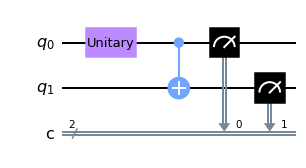

In [1203]:
# Orthonormalize the weights
U = gs_2d_real(model_weights)

# Initialize Quantum Circuit
circ = QuantumCircuit(2, 2)

# Apply weights matrix as unitary gate
circ.unitary(U, 0)

# Apply CX
circ.cx(0, 1)

# Measure
circ.measure([0, 1], [0, 1])

# Draw Circuit
circ.draw('mpl')

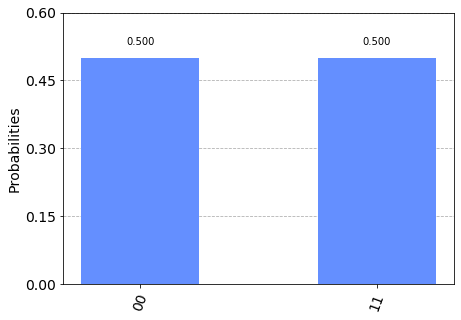

In [1204]:
simulator = Aer.get_backend('qasm_simulator')

# For Mathematical Representation
results = execute(circ, simulator).result()

# Count Results
counts = results.get_counts(circ)

# Plot Histogram
plot_histogram(counts)